<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/AI-cybersecurity/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.stats import ttest_ind


In [48]:
path = kagglehub.dataset_download("whenamancodes/infoseccyber-security-salaries")

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))

Using Colab cache for faster access to the 'infoseccyber-security-salaries' dataset.
Path to dataset files: /kaggle/input/infoseccyber-security-salaries
Files in dataset folder: ['Cyber_salaries.csv']


In [49]:
df = pd.read_csv(os.path.join(path, "Cyber_salaries.csv"))

print("Size rows/columns:", df.shape)

print(df.isnull().sum())

df.describe()

Size rows/columns: (1349, 11)
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


,work_year,salary,salary_in_usd,remote_ratio
count,1349.000000,1.349000e+03,1349.000000,1349.000000
mean,2021.368421,5.288248e+05,121578.622683,72.238695
std,0.711236,1.361367e+07,68972.954838,39.355331
min,2020.000000,1.740000e+03,2000.000000,0.000000
25%,2021.000000,8.000000e+04,75000.000000,50.000000
50%,2022.000000,1.200000e+05,115000.000000,100.000000
75%,2022.000000,1.600800e+05,152000.000000,100.000000
max,2022.000000,5.000000e+08,899920.000000,100.000000


In [71]:
df = df[['experience_level',
         'salary_in_usd', 'remote_ratio']]

X_dummies = pd.get_dummies(df).astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X_dummies)
print(X_dummies )

      salary_in_usd  remote_ratio  experience_level_EN  experience_level_EX  \
0             72762           100                    1                    0   
1            123400             0                    0                    0   
2             88100             0                    0                    0   
3            163575           100                    0                    0   
4            115800           100                    0                    0   
...             ...           ...                  ...                  ...   
1344          96422            50                    0                    0   
1345          82528            50                    0                    0   
1346         126000           100                    0                    0   
1347          57769           100                    0                    0   
1348          66310             0                    0                    0   

      experience_level_MI  experience_level_SE  
0 

# K-DISTANCE ГРАФІК ДЛЯ ВИБОРУ EPS

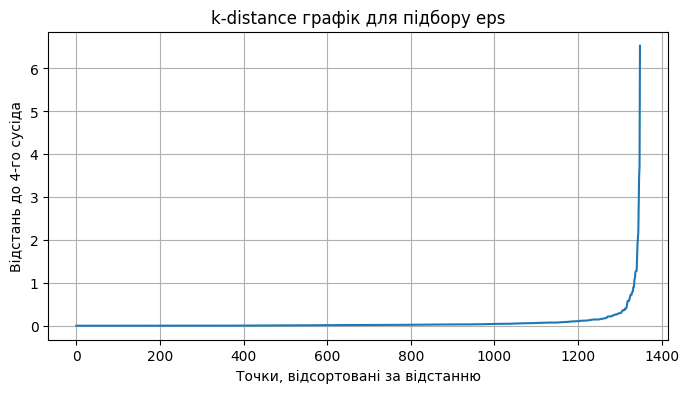

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.xlabel("Точки, відсортовані за відстанню")
plt.ylabel(f"Відстань до {k}-го сусіда")
plt.title("k-distance графік для підбору eps")
plt.grid(True)
plt.show()


# DBSCAN

In [73]:
eps_value = 1.2
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
cluster_labels = dbscan.fit_predict(X_scaled)

df["cluster_dbscan"] = cluster_labels

print("Унікальні кластери (включно з шумом -1):", np.unique(cluster_labels))
print("\nКількість об'єктів у кожному кластері:")
print(df["cluster_dbscan"].value_counts())


Унікальні кластери (включно з шумом -1): [-1  0  1  2  3  4  5  6  7  8  9 10 11]

Кількість об'єктів у кожному кластері:
cluster_dbscan
 2     456
 3     228
 4     111
 0     110
 8      91
 1      89
 11     71
 9      63
 5      51
 10     45
 6      18
-1      10
 7       6
Name: count, dtype: int64


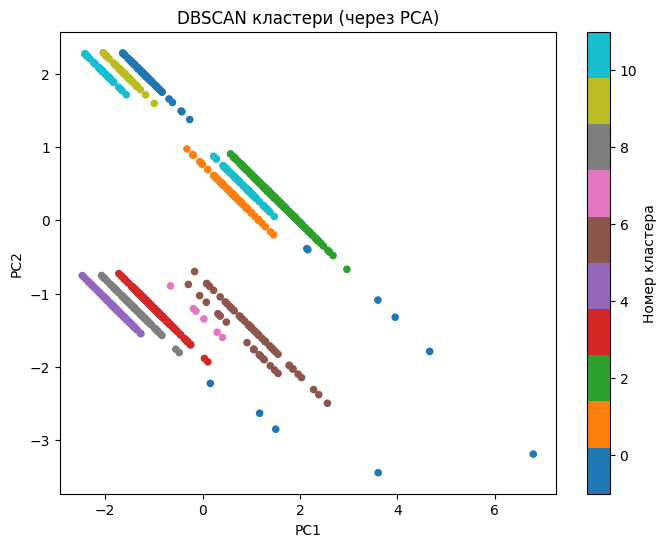

In [74]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN кластери (через PCA)")
plt.colorbar(scatter, label="Номер кластера")
plt.show()


# A/B-ТЕСТ

In [75]:
group_col = "experience_level"
metric_col = "salary_in_usd"

print("Унікальні значення в груповій ознаці:")
print(df[group_col].unique())


Унікальні значення в груповій ознаці:
['EN' 'SE' 'MI' 'EX']


In [76]:
unique_groups = df[group_col].dropna().unique()

if len(unique_groups) < 2:
    raise ValueError("Для A/B-тесту потрібно мінімум 2 групи в колонці " + group_col)

group_A_value = unique_groups[0]
group_B_value = unique_groups[1]

print("Група A:", group_A_value)
print("Група B:", group_B_value)

group_A = df[df[group_col] == group_A_value][metric_col].dropna()
group_B = df[df[group_col] == group_B_value][metric_col].dropna()

print(f"Розмір групи A: {len(group_A)}")
print(f"Розмір групи B: {len(group_B)}")


Група A: EN
Група B: SE
Розмір групи A: 218
Розмір групи B: 622


In [77]:
def ab_test_simple(group_A, group_B):
    mean_A = np.mean(group_A)
    mean_B = np.mean(group_B)

    print(f"Середнє значення в групі A: {mean_A:.2f}")
    print(f"Середнє значення в групі B: {mean_B:.2f}")

    if mean_B > mean_A:
        print("Група B 'перевершує' групу A (більше середнє значення).")
    elif mean_B < mean_A:
        print("Група A 'перевершує' групу B (більше середнє значення).")
    else:
        print("Середні значення однакові.")

ab_test_simple(group_A, group_B)


Середнє значення в групі A: 63726.62
Середнє значення в групі B: 145937.45
Група B 'перевершує' групу A (більше середнє значення).


In [78]:
t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False)

print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("Різниця статистично значуща (відхиляємо H0).")
else:
    print("Немає статистично значущої різниці (не відхиляємо H0).")


t-статистика: -23.9546
p-value: 0.000000
Різниця статистично значуща (відхиляємо H0).


/tmp/ipython-input-1130089522.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group_A, group_B], labels=[f"A: {group_A_value}", f"B: {group_B_value}"])


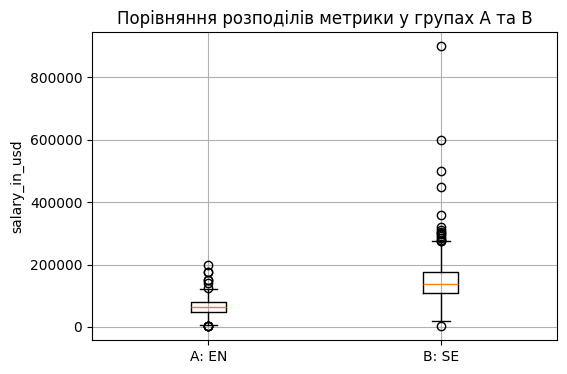

In [79]:
plt.figure(figsize=(6, 4))
plt.boxplot([group_A, group_B], labels=[f"A: {group_A_value}", f"B: {group_B_value}"])
plt.ylabel(metric_col)
plt.title("Порівняння розподілів метрики у групах A та B")
plt.grid(True)
plt.show()


# Висновки

Попередній аналіз показав, що датасет складається з 1349 записів та 11 ознак без пропусків. Для подальшого аналізу було відібрано найбільш інформативні змінні: experience_level, salary_in_usd та remote_ratio. Категоріальні значення рівня досвіду було перетворено у числовий формат за допомогою one-hot-encoding, після чого всі ознаки були стандартизовані засобами StandardScaler, що є необхідною умовою для коректної роботи DBSCAN у багатовимірному просторі.

Для вибору параметра ε було побудовано k-distance графік при k = 4 (що відповідає min_samples = 5, рекомендованому в класичній літературі з DBSCAN). Графік продемонстрував чіткий «лікоть» у діапазоні ε ≈ 1.2, що свідчить про оптимальне відокремлення точок високої щільності від потенційних викидів.

Після налаштування eps = 1.2 та min_samples = 5 алгоритм DBSCAN сформував 12 кластерів, включно з кластером шуму (–1). Розподіл елементів між кластерами виявив суттєву різницю в їхній чисельності: найбільші кластери (кластер 2 та кластер 3) містять 456 та 228 записів відповідно, тоді як у найменших кластерах — лише по 6–18 об’єктів. Це свідчить про наявність у вибірці як чітко окреслених груп за ознаками зарплати, рівня досвіду та формату віддаленої роботи, так і невеликих локальних структур, що відображають специфічні й рідкісні комбінації значень ознак.

Візуалізація результатів у просторі перших двох головних компонент (PCA) підтвердила наявність множинних щільних областей, чітко відокремлених одна від одної, що свідчить про коректність кластеризації та адекватність обраних параметрів.

Проведення A/B-тестування

Для ілюстрації роботи A/B-тесту була обрана категоріальна змінна experience_level. Було сформовано дві групи:

Група A (EN — Entry-level)

Група B (SE — Senior-level)

У ролі метрики виступала годова зарплата, нормалізована за валютою — salary_in_usd. Результати показали суттєву різницю між середніми значеннями:

EN: 63 726 USD

SE: 145 937 USD

Подальший аналіз за допомогою t-тесту (без припущення рівності дисперсій, Welch’s t-test) дав такі результати:

t-статистика: –23.95

p-value: < 0.000001

Оскільки p < 0.05, нульову гіпотезу про відсутність різниці в середніх значеннях відхилено. Це означає, що рівень досвіду має статистично значущий вплив на рівень заробітної плати у сфері кібербезпеки.


Алгоритм DBSCAN дозволив виділити багатоструктурну кластерну організацію у даних, що вказує на складну внутрішню гетерогенність ринку праці в сфері кібербезпеки.

Найбільші кластери відповідають типовим комбінаціям рівня досвіду, рівня оплати праці та режиму роботи (on-site/remote), тоді як малі кластери відображають рідкісні або вузькоспеціалізовані профілі.

Метод A/B-тестування підтвердив, що рівень досвіду суттєво впливає на заробітну плату, причому різниця між групами EN та SE є статистично значущою.

Застосовані методи дали змогу не лише виявити приховану структуру даних, а й перевірити гіпотези про вплив окремих ознак, що демонструє комплексний підхід до аналізу реального датасету.